# Pairs Trading Notebook

## Magic

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import datetime as dt
import numpy as np
import plotnine as p9
import pandas as pd
import polars as pl
import yfinance as yf

## Options

In [3]:
p9.options.figure_size = (12, 5)

## Stock Ticker Definitions

In [4]:
stk1 = 'HLT'
stk2 = 'MAR'

## Getting Data from YahooFinance

In [5]:
tickers = yf.Tickers([stk1, stk2])
# yahoo_data = tickers.download(start=dt.date(2000, 1, 1), auto_adjust=True)
yahoo_data = tickers.download(period="max", auto_adjust=True)

[*********************100%%**********************]  2 of 2 completed


In [6]:
yd = (
    pl
    .from_dataframe(
        yahoo_data
        .stack(1, future_stack=True)
        .reset_index()
        .assign(Date=lambda x: pd.to_datetime(x['Date']).dt.tz_localize(None))
    )
    .select('Date', 'Ticker', 'Close')
    .rename(lambda x: x.lower())
    .pivot(on='ticker', index='date').drop_nulls()
)

## Creating Entry / Exit Signals from rolling Z-Score

The idea is to buy when the rolling z-score is below -0.5 (lower_bound) and close out at zero
Similarly for the short side.  Sell when above 0.5 and close out at zero

In [7]:
upper_bound = 0.5
lower_bound = -0.5

yd_data = (
    yd
    .with_columns(
        (pl.col(stk1) / pl.col(stk2)).alias('ratio')
    )
    .with_columns(
        pl.col('ratio').rolling_mean(window_size=20, min_periods=20).alias('ratio_mn'),
        pl.col('ratio').rolling_std(window_size=20, min_periods=20).alias('ratio_std')
    )
    .with_columns(
        (( pl.col('ratio') - pl.col('ratio_mn') ) / pl.col('ratio_std')).alias('ratio_z')
    )
    .drop_nulls()
    .with_columns(
        pl.when(pl.col('ratio_z') < lower_bound).then(1).otherwise(0).alias('long_entry'),
        pl.when(pl.col('ratio_z') > 0).then(1).otherwise(0).alias('long_exit')
    )
    .with_columns(
        pl.when(pl.col('ratio_z') > upper_bound).then(1).otherwise(0).alias('short_entry'),
        pl.when(pl.col('ratio_z') < 0).then(1).otherwise(0).alias('short_exit')
    )
    
)

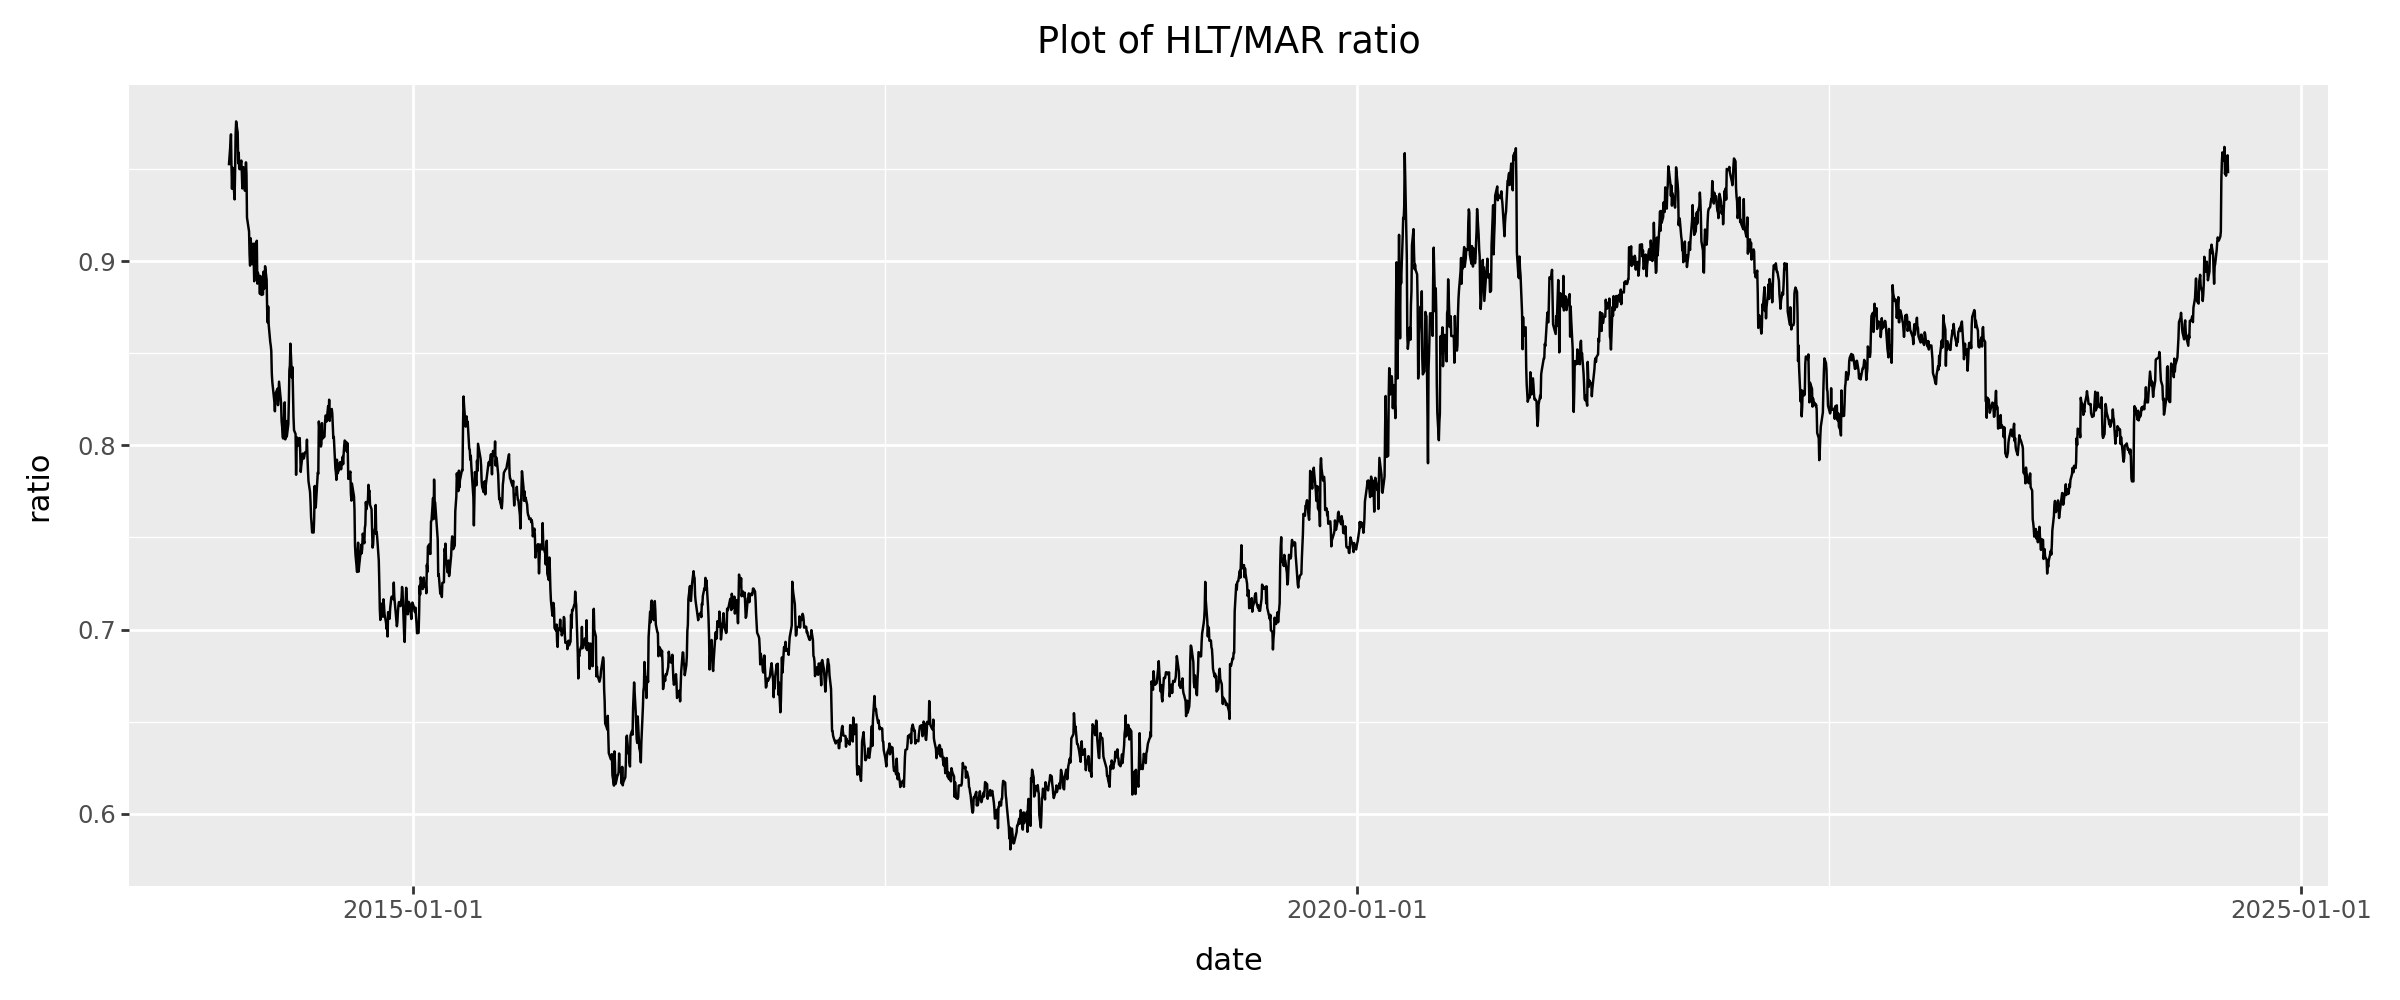

In [8]:
(
    yd_data
    .pipe(p9.ggplot)
    + p9.aes(x='date', y='ratio')
    + p9.geom_line()
    + p9.ggtitle(f"Plot of {stk1}/{stk2} ratio")
)

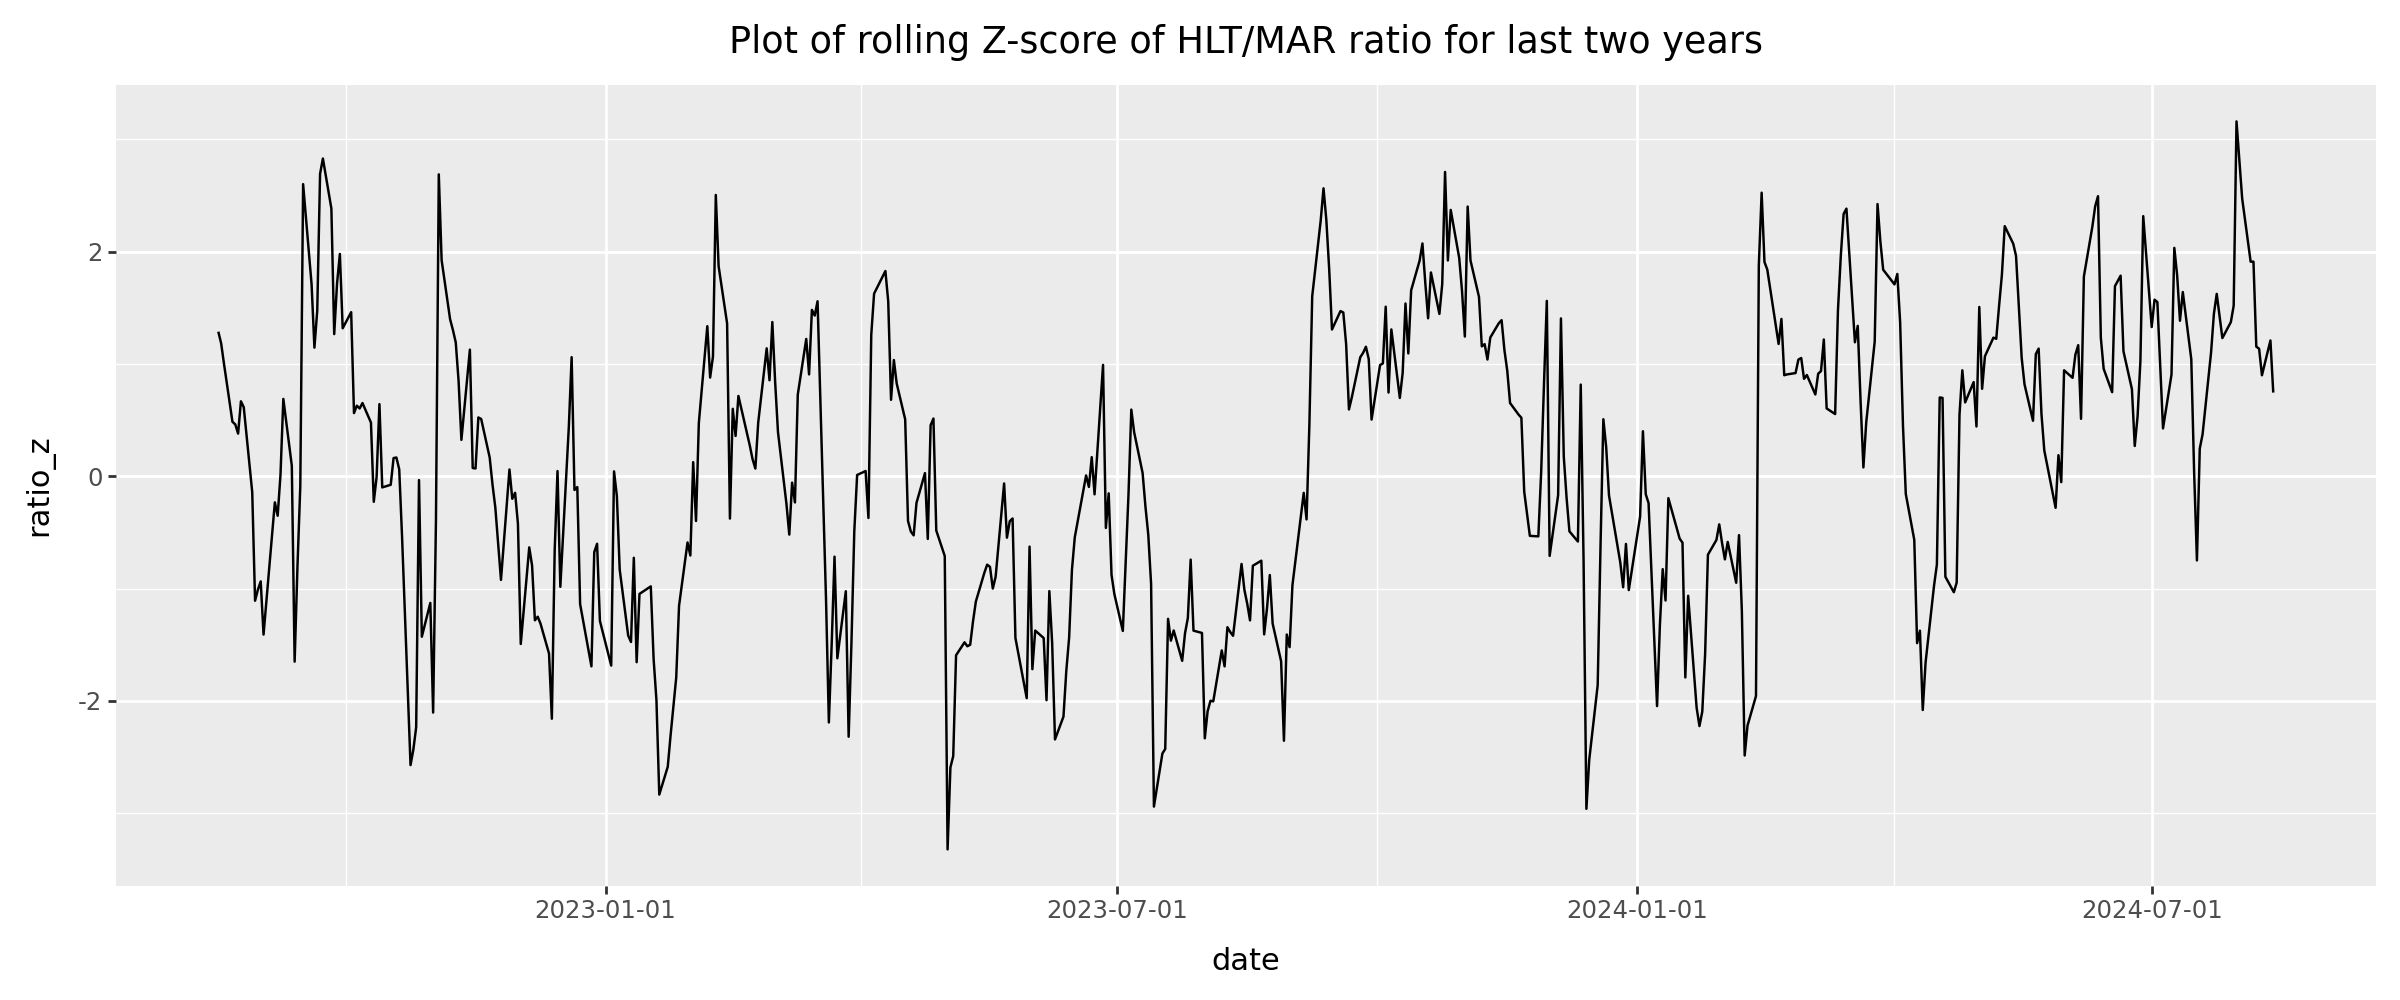

In [9]:
(
    yd_data[-500:]  # last two years worth
    .pipe(p9.ggplot)
    + p9.aes(x='date', y='ratio_z')
    + p9.geom_line()
    + p9.ggtitle(f"Plot of rolling Z-score of {stk1}/{stk2} ratio for last two years")
)

## Running Long and Short Sides of Pairs

In [10]:
posn_long = np.array(len(yd_data)*[0])
entry_ratio_long = np.array(len(yd_data)*[0.0])

prev_posn = 0
prev_ratio = 0

for i, (ratio, entry, exit) in enumerate(zip(yd_data['ratio'], yd_data['long_entry'], yd_data['long_exit'])):
    if entry == 1:
        posn_long[i] = 1
    elif exit == 1:
        posn_long[0] = 0
    else:
        posn_long[i] = prev_posn

    if posn_long[i] == 1 and prev_posn == 0:
        entry_ratio_long[i] = ratio
    elif prev_ratio != 0 and posn_long[i] == 0:
        entry_ratio_long[i] = 0
    else:
        entry_ratio_long[i] = prev_ratio
    
    prev_ratio = entry_ratio_long[i]
    prev_posn = posn_long[i]

In [11]:
posn_short = np.array(len(yd_data)*[0])
entry_ratio_short = np.array(len(yd_data)*[0.0])

prev_posn = 0
prev_ratio = 0

for i, (ratio, entry, exit) in enumerate(zip(yd_data['ratio'], yd_data['short_entry'], yd_data['short_exit'])):
    # if i > 0:
    #     break
    # print(ratio, entry, exit)
    
    if entry ==1:
        posn_short[i] = 1
    elif exit == 1:
        posn_short[i] = 0
    else:
        posn_short[i] = prev_posn

    if posn_short[i] == 1 and prev_posn == 0:
        entry_ratio_short[i] = ratio
    elif prev_ratio != 0 and posn_short[i] == 0:
        entry_ratio_short[i] = 0
    else:
        entry_ratio_short[i] = prev_ratio
    
    prev_ratio = entry_ratio_short[i]
    prev_posn = posn_short[i]

## Calculate cumulative PLs, Chart the Total PL, and calcluate a "Sharpe Ratio"

In [12]:
result = (            
    yd_data
    .with_columns(
        long_posn = posn_long, 
        long_entry_ratio=entry_ratio_long,
        short_posn = posn_short,
        short_entry_ratio=entry_ratio_short
    )
    .with_columns(
        long_pl = pl.col('long_posn').shift(1) * ( pl.col(stk1) - pl.col(stk1).shift(1) - pl.col('long_entry_ratio').shift(1) * (pl.col(stk2) - pl.col(stk2).shift(1))),
        short_pl = -pl.col('short_posn').shift(1) * ( pl.col(stk1) - pl.col(stk1).shift(1) - pl.col('short_entry_ratio').shift(1) * (pl.col(stk2) - pl.col(stk2).shift(1))),
    )
    .with_columns(
        long_cpl = pl.col('long_pl').cum_sum(),
        short_cpl = pl.col('short_pl').cum_sum(),
        total_cpl = (pl.col('long_pl') + pl.col('short_pl')).cum_sum()
    )
)
        

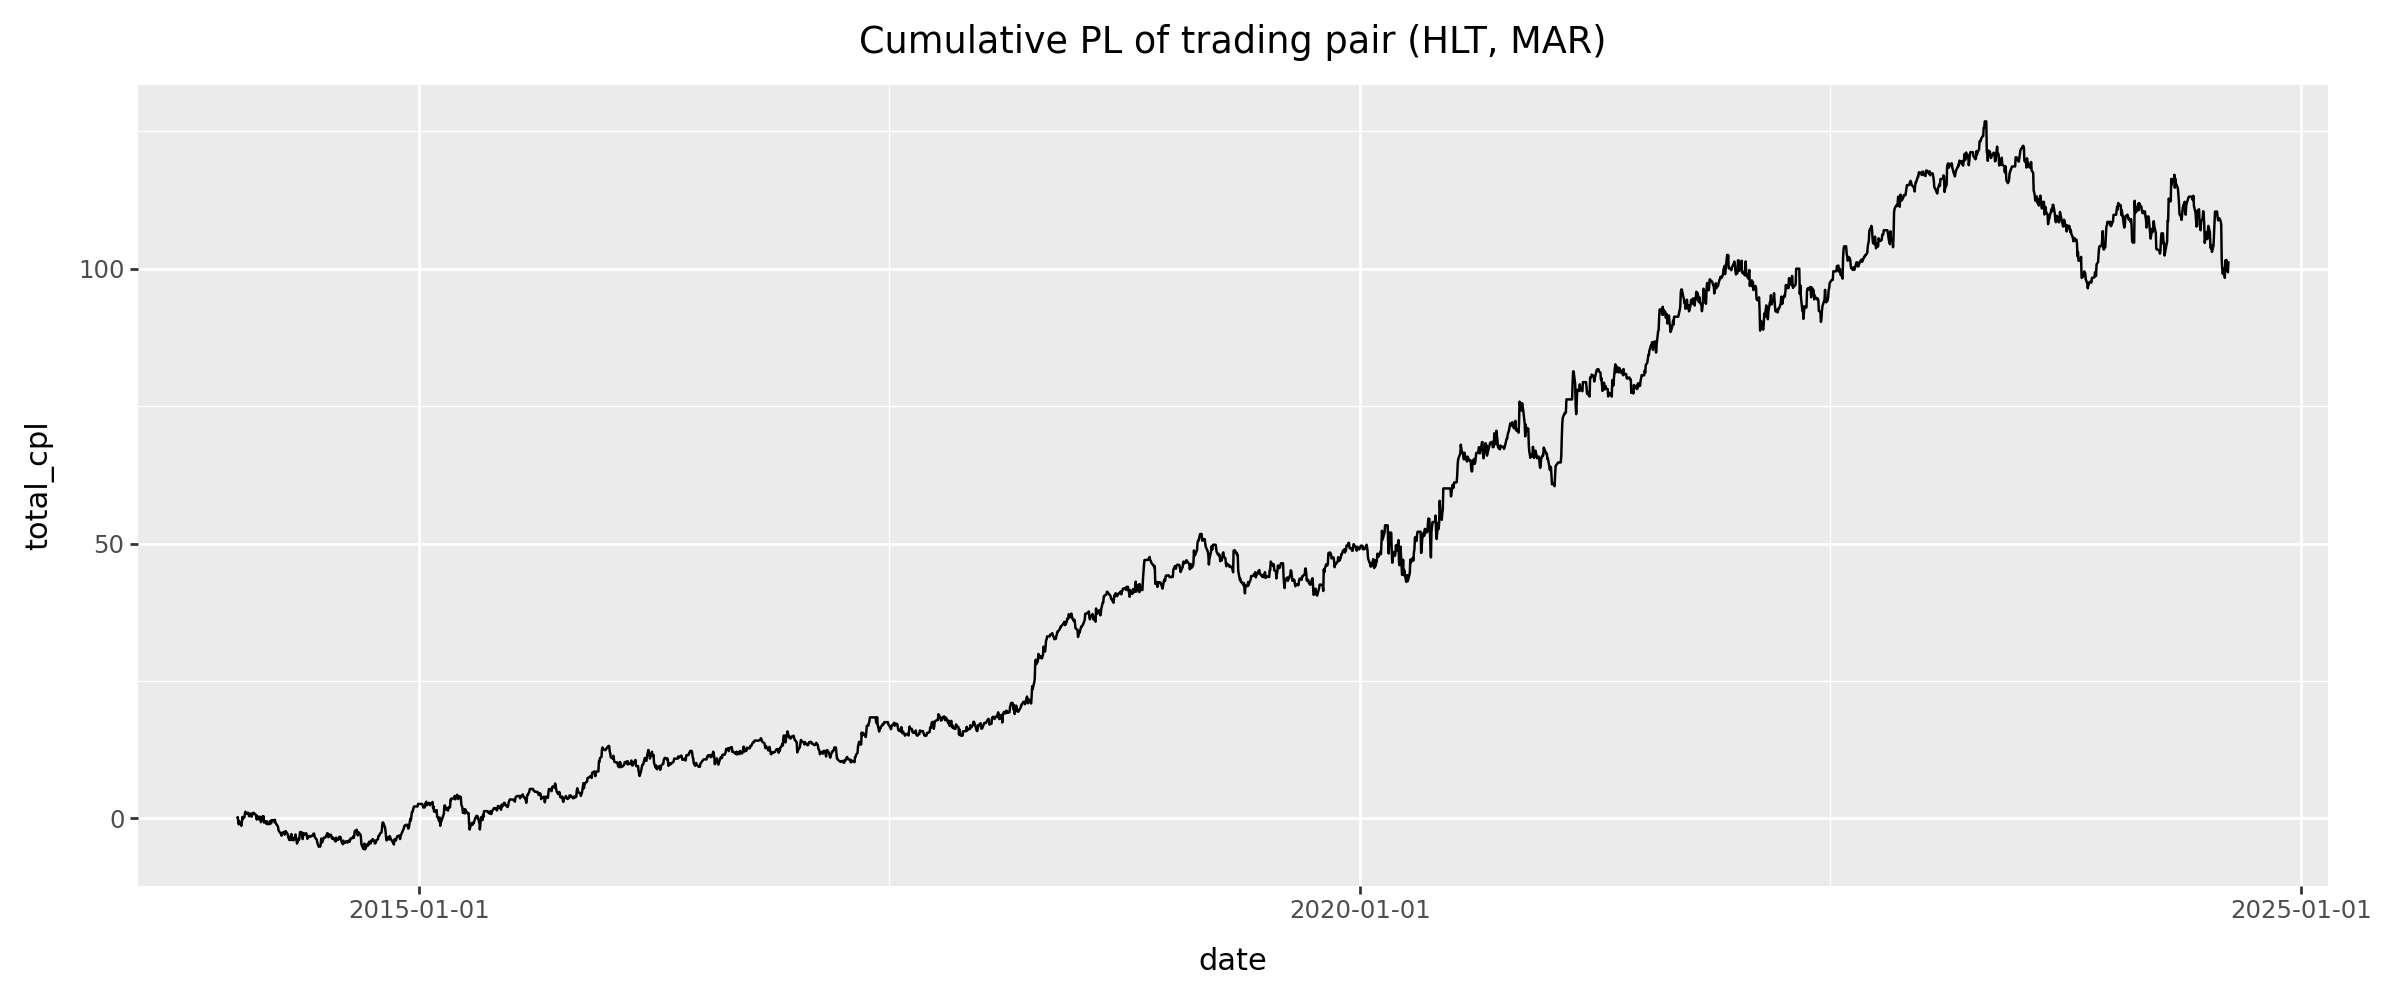

In [13]:
(
    result
    .drop_nulls()
    .pipe(p9.ggplot)
    + p9.aes(x='date', y='total_cpl')
    + p9.geom_line()
    + p9.ggtitle(f"Cumulative PL of trading pair ({stk1}, {stk2})")
)

In [14]:
pl_result = result['long_pl'] + result['short_pl']
mean_ret = pl_result.mean()
std = pl_result.std()
sr = mean_ret / std * np.sqrt(252)
print(f"Sharpe Ratio: {sr:.2f}")

Sharpe Ratio: 0.66
